# Tariff recommendation

You have at your disposal data on the behavior of customers who have already switched to these tariffs (from the course project "Statistical Data Analysis"). You need to build a model for a classification task that will select the appropriate tariff. You don't need to preprocess the data - you've already done it.

Build the model with the largest *accuracy* value possible. To pass the project successfully, you need to get the proportion of correct answers to at least 0.75. Check the *accuracy* on the test sample yourself.

Each object in the dataset is information about one user's behavior in a month. Known:

    calls - number of calls,
    minutes - total duration of calls in minutes,
    messages - number of sms-messages,
    mb_used - used Internet traffic in Mb,
    is_ultra - what tariff was used during the month ("Ultra" - 1, "Smart" - 0).

## Open and examine the file

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')

In [3]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [5]:
df['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

**We see twice as many people not on the Ultra plan**

## Split the data into samples

In [6]:
features = df.drop('is_ultra', axis=1)
target = df['is_ultra']

In [7]:
features_train, features_valid, target_train, target_valid  = train_test_split(features, target, test_size=0.2,  random_state = 12345)

In [8]:
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5,  random_state = 12345)

## Explore the models

In [11]:
# decision tree classifier
best_dtc_model = None
best_dtc_result = 0
best_dtc_depth = 0
depth_pl = []
result_pl = []

for depth in range(1,30):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train,target_train)
    prediction = model.predict(features_valid)
    result = accuracy_score(target_valid, prediction)
    depth_pl.append(depth)
    result_pl.append(result)
    if result > best_dtc_result:
        best_dtc_model = model
        best_dtc_result = result
        best_dtc_depth = depth

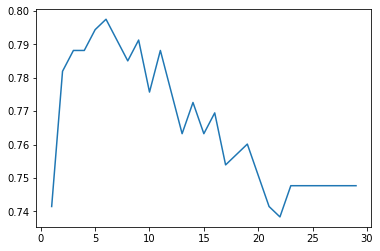

In [12]:
plt.plot(depth_pl, result_pl)

The optimal number of trees is 6, because then the accuracy decreases and the model is retrained.

In [13]:
# random forest classifier
best_rfc_model = None
best_rfc_result = 0
best_rfc_estimators_number = 0
pl_estimators=[_ for _ in range(1,10)]
pl_depth = [_ for _ in range(1,10)]
pl_result = []
for est in range(1,10):
        for depth in range(1,10):
            model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
            model.fit(features_train, target_train)
            prediction = model.predict(features_valid)
            result = accuracy_score(target_valid, prediction)
            pl_result.append(result)
            if result > best_rfc_result:
                best_rfc_model = model
                best_rfc_result = result
                best_rfc_estimators_number = est

In [14]:
pl_result = [pl_result[x:x+9] for x in range(0, len(pl_result), 9)]


Text(33.0, 0.5, 'Number of estimators')

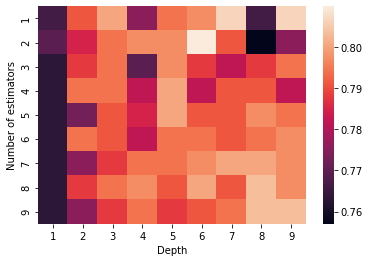

In [15]:
sns.heatmap(data=pl_result, xticklabels=pl_depth, yticklabels=pl_estimators)
plt.xlabel("Depth")
plt.ylabel("Number of estimators")

We see that the best result is shown by the model with the number of estimators 2 and tree depth 6.

In [16]:
# logistic regression
best_lg_model = None
best_lg_result = 0
best_lg_iter = 0
pl_iter = [_ for _ in range(500, 10000, 500)]
p_result = []
for it in range(500, 10000, 500):
    model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=it)
    model.fit(features_train, target_train)
    prediction = model.predict(features_valid)
    result = accuracy_score(target_valid, prediction)
    p_result.append(result)
    if result > best_lg_result:
        best_lg_model = model
        best_lg_result = result
        best_lg_iter = it


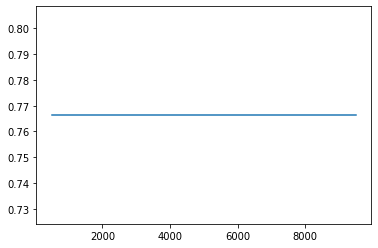

In [17]:
plt.plot(pl_iter,p_result)

No change in the quality of the predictions.

In [18]:
models = [best_dtc_model, best_rfc_model, best_lg_model]
results = [best_dtc_result, best_rfc_result, best_lg_result]
parameters = [best_dtc_depth, best_rfc_estimators_number, best_lg_iter]

frame = {'models': models, 'parameters':parameters, 'results':results}
validation_result = pd.DataFrame(frame)

In [19]:
validation_result

,models,parameters,results
0,"DecisionTreeClassifier(max_depth=6, random_sta...",6,0.797508
1,"(DecisionTreeClassifier(max_depth=6, max_featu...",2,0.809969
2,"LogisticRegression(max_iter=500, random_state=...",500,0.766355


The best result was shown by the random forest model with the number of evaluators 2 and maximum depth 6.
The decision tree model with a depth of 6 is in second place.
However, the difference between the accuracy of the decision tree and random forest is insignificant.

Logistic regression performed the worst. 


## Validate the model on a test sample

In [20]:
prediction = best_rfc_model.predict(features_test)
accuracy = accuracy_score(prediction, target_test)
print('Точность предсказания модели', str(best_rfc_model).split('(')[0], '=', accuracy)

Точность предсказания модели RandomForestClassifier = 0.7732919254658385


The RandomForestClassifier model managed to achieve an accuracy greater than 0.75

I'll try to take and test on just zeroes

In [21]:
adequacy_df = df[df['is_ultra']==0] 

In [22]:
adequacy_features = adequacy_df.drop('is_ultra', axis=1)
adequacy_target = adequacy_df['is_ultra']

In [23]:
adeq_result = best_rfc_model.predict(adequacy_features)

In [24]:
accuracy_score(adeq_result, adequacy_target)

0.9528936742934051

The adequacy of the best model is 0.95
